In [93]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt 
%matplotlib inline

import random as rand


# Data


In [94]:
#import data
df = pd.read_csv('NFL.csv')
df = df[(df['Drafted']=='Yes')]

In [95]:
feature_names = df.columns
print("list of features name and type")
for i in range(len(df.columns)):
    print(str(i), "\t", str(feature_names[i]),"\t\t\t", str(type(df.iloc[0,i])))

list of features name and type
0 	 Year 			 <class 'numpy.int64'>
1 	 Player 			 <class 'str'>
2 	 Age 			 <class 'numpy.float64'>
3 	 School 			 <class 'str'>
4 	 Height 			 <class 'numpy.float64'>
5 	 Weight 			 <class 'numpy.float64'>
6 	 Sprint_40yd 			 <class 'numpy.float64'>
7 	 Vertical_Jump 			 <class 'numpy.float64'>
8 	 Bench_Press_Reps 			 <class 'numpy.float64'>
9 	 Broad_Jump 			 <class 'numpy.float64'>
10 	 Agility_3cone 			 <class 'numpy.float64'>
11 	 Shuttle 			 <class 'numpy.float64'>
12 	 Drafted..tm.rnd.yr. 			 <class 'str'>
13 	 BMI 			 <class 'numpy.float64'>
14 	 Player_Type 			 <class 'str'>
15 	 Position_Type 			 <class 'str'>
16 	 Position 			 <class 'str'>
17 	 Drafted 			 <class 'str'>


In [96]:
df.head()

,Year,Player,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Drafted..tm.rnd.yr.,BMI,Player_Type,Position_Type,Position,Drafted
0,2009,Beanie Wells\WellCh00,20.0,Ohio St.,1.8542,106.594207,4.38,85.09,25.0,325.12,NaN,NaN,Arizona Cardinals / 1st / 31st pick / 2009,31.004194,offense,backs_receivers,RB,Yes
1,2009,Will Davis\DaviWi99,22.0,Illinois,1.8796,118.387609,4.84,83.82,27.0,292.10,7.38,4.45,Arizona Cardinals / 6th / 204th pick / 2009,33.510073,defense,defensive_lineman,DE,Yes
2,2009,Herman Johnson\JohnHe23,24.0,LSU,2.0066,165.107623,5.50,NaN,21.0,NaN,NaN,NaN,Arizona Cardinals / 5th / 167th pick / 2009,41.005821,offense,offensive_lineman,OG,Yes
3,2009,Rashad Johnson\JohnRa98,23.0,Alabama,1.8034,92.079251,4.49,93.98,15.0,304.80,7.09,4.23,Arizona Cardinals / 3rd / 95th pick / 2009,28.312463,defense,defensive_back,FS,Yes
4,2009,Cody Brown\BrowCo96,22.0,Connecticut,1.8796,110.676538,4.76,92.71,26.0,304.80,7.10,4.40,Arizona Cardinals / 2nd / 63rd pick / 2009,31.327425,defense,line_backer,OLB,Yes


# Data cleaning

Fix Drafted data: (Team, Draft_Round, pick, year)

In [97]:
df = df.rename(columns = {'Drafted..tm.rnd.yr.':'Pick'})
df[['Team','Draft_Round','pick','year']] = df.Pick.str.split('/', expand = True)
df = df.drop(columns=["Pick"])
#strip spaces
df['Team'] = df['Team'].str.strip()
df['pick'] = df['pick'].str.strip()
df['Draft_Round'] = df['Draft_Round'].str.strip()
df['year'] = df['year'].str.strip()
#convert pick to number
df['pick']=df['pick'].apply(lambda x: (x.split("s")[0]))
df['pick']=df['pick'].apply(lambda x: (x.split("r")[0]))
df['pick']=df['pick'].apply(lambda x: (x.split("t")[0]))
df['pick']=df['pick'].apply(lambda x: (int(x.split("n")[0])))
#convert draft round to number
df['Draft_Round']=df['Draft_Round'].apply(lambda x: (x.split("s")[0]))
df['Draft_Round']=df['Draft_Round'].apply(lambda x: (x.split("r")[0]))
df['Draft_Round']=df['Draft_Round'].apply(lambda x: (x.split("t")[0]))
df['Draft_Round']=df['Draft_Round'].apply(lambda x: (int(x.split("n")[0])))
#remove year
df = df.drop(columns=["year"])

Fixing NA

In [98]:
#create column to represent if value is null
df["Age_NA"] = df["Age"].isna().astype(int)
df["Sprint_40yd_NA"] = df["Sprint_40yd"].isna().astype(int)
df["Vertical_Jump_NA"] = df["Vertical_Jump"].isna().astype(int)
df["Bench_Press_Reps_NA"] = df["Bench_Press_Reps"].isna().astype(int)
df["Broad_Jump_NA"] = df["Broad_Jump"].isna().astype(int)
df["Agility_3cone_NA"] = df["Agility_3cone"].isna().astype(int)
df["Shuttle_NA"] = df["Shuttle"].isna().astype(int)


standardize data

In [99]:
labels_real =["Year","Age", "Height","Weight","Sprint_40yd","Vertical_Jump", "Bench_Press_Reps",
"Broad_Jump", "Agility_3cone", "Shuttle", "BMI"]
for i in labels_real:
  df[i] = (df[i] - np.mean(df[i]))/ np.std(df[i])

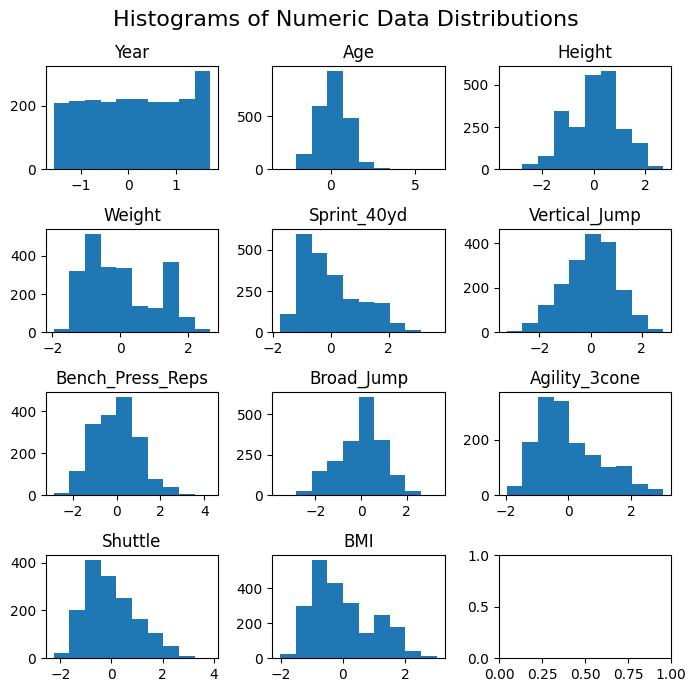

In [100]:
num_labels =["Year", "Age","Height","Weight","Sprint_40yd","Vertical_Jump", "Bench_Press_Reps",
"Broad_Jump", "Agility_3cone", "Shuttle", "BMI"]

fig, axs = plt.subplots(nrows = 4, ncols=3,figsize=(7, 7))
fig.suptitle("Histograms of Numeric Data Distributions", fontsize=16)
i=0
for x in range(4):
  for y in range(3):
    if i < 11:
      axs[x,y].hist(df[num_labels[i]])
      axs[x,y].set_title(num_labels[i])
      i=i+1
fig.tight_layout(pad=1)

In [101]:
df = df.fillna(0)

Add offset

In [102]:
df['Offset'] = 1

# Run Model


In [103]:
# This function just computes the mean squared error
def MSE(y, pred):
    return 1/len(y) * sum((y-pred)**2)

# This function plots the main diagonal;for a "predicted vs true" plot with perfect predictions, all data lies on this line
def plotDiagonal(xmin, xmax):
    xsamples = np.arange(xmin,xmax,step=0.01)
    plt.plot(xsamples,xsamples,c='black')

# This helper function plots x vs y and labels the axes
def plotdata(x=None,y=None,xname=None,yname=None,margin=0.05,plotDiag=True,zeromin=False):
    plt.scatter(x,y,label='data')
    plt.xlabel(xname)
    plt.ylabel(yname)
    range_x = max(x) - min(x)
    range_y = max(y) - min(y)
    if plotDiag:
        plotDiagonal(min(x)-margin*range_x,max(x)+margin*range_x)
    if zeromin:
        plt.xlim(0.0,max(x)+margin*range_x)
        plt.ylim(0.0,max(y)+margin*range_y)
    else:
        plt.xlim(min(x)-margin*range_x,max(x)+margin*range_x)
        plt.ylim(min(y)-margin*range_y,max(y)+margin*range_y)
    plt.show()

# This function plots the predicted labels vs the actual labels (We only plot the first 1000 points to avoid slow plots)
def plot_pred_true(test_pred=None, test_y=None, max_points = 1000):
    plotdata(test_pred[1:max_points], test_y[1:max_points],'Predicted', 'True', zeromin=True)

# This function runs OLS and bypasses any SVD (Singular Value Decomposition) convergence errors by refitting the model
def run_OLS(train_y, test_y, train_vals, test_vals):
    ols_model = sm.regression.linear_model.OLS(train_y, train_vals)
   
    while True: # Bypasses SVD convergence assertion error
        try:
            results = ols_model.fit()
            break
        except:
            None     
    w = np.array(results.params).reshape([len(results.params),1])
    train_pred = np.matmul(train_vals,w)
    test_pred = np.matmul(test_vals,w)
    train_MSE = MSE(train_y, train_pred.flatten())
    test_MSE = MSE(test_y, test_pred.flatten())
    
    return train_MSE, test_MSE, test_pred, w

In [104]:
def onehot(column=None, col=None):
    extra_columns = ["label:"+ str(i) for i in range(len(col))]
    add_on = pd.Series(col, extra_columns)
    new = pd.concat([add_on, column])
    encoded = pd.get_dummies(new, dtype=int)
    drop_one = encoded.drop(extra_columns)
    return drop_one.drop(columns = list(set(drop_one.columns.values) - set(col))).to_numpy()


def onehot_col_val(column=None, col=None):
    extra_columns = ["label:"+ str(i) for i in range(len(col))]
    add_on = pd.Series(col, extra_columns)
    new = pd.concat([add_on, column])
    encoded = pd.get_dummies(new, dtype=int)
    drop_one = encoded.drop(extra_columns)
    return list((drop_one.drop(columns = list(set(drop_one.columns.values) - set(col)))).columns.values)

def run(df, cat_labels, num_labels, pred, train_prop = 0.8):
  
  #Train and test
  df = df.sample(frac = 1, random_state=1) # we shuffle the data so that our train/test split will be truly random
  train_proportion = train_prop
  n = len(df)
# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
  t = int(train_proportion * n)
  target = df[pred]
  pick_columns = ['pick','Draft_Round']
  data = df.loc[:, ~df.columns.isin(pick_columns)]
  train_x = data.iloc[:t-1,:]
  test_x = data.iloc[t:,:]
  train_y = target[:t-1]
  test_y = target[t:]

  #real values
  labels_list= list(num_labels)
  train_num_vals = np.asarray(train_x[num_labels])
  test_num_vals= np.asarray(test_x[num_labels])

  #cat labels
  if cat_labels != []:
    cats_sets = [train_x.loc[:, label].unique() for label in cat_labels]
    #print(len(cats_sets))
    train_cat_vals = np.concatenate([onehot(train_x[cat_labels[k]],cats_sets[k]) 
                                 for k in range(len(cat_labels))],axis =1)    
    test_cat_vals = np.concatenate([onehot(test_x[cat_labels[k]],cats_sets[k]) 
                                 for k in range(len(cat_labels))],axis =1)  
    train_vals = np.concatenate((train_num_vals, train_cat_vals), axis=1)
    test_vals = np.concatenate((test_num_vals, test_cat_vals), axis=1)
  else:
    train_vals = train_num_vals
    test_vals = test_num_vals

  for k in range(len(cat_labels)):
    vals = onehot_col_val(train_x[cat_labels[k]],cats_sets[k])
    labels_list = labels_list + vals

  #run model
  train_MSE, test_MSE, test_pred, w = run_OLS(train_y, test_y, train_vals, test_vals)
  print("Train MSE\t", str(train_MSE))
  print("Test MSE\t", str(test_MSE))
  plot_pred_true(test_pred.flatten(), test_y) #.flatten() will make sure the dimensions match

  return w, labels_list

  

All features

Train MSE	 3580.834838315408
Test MSE	 4635.457434005362


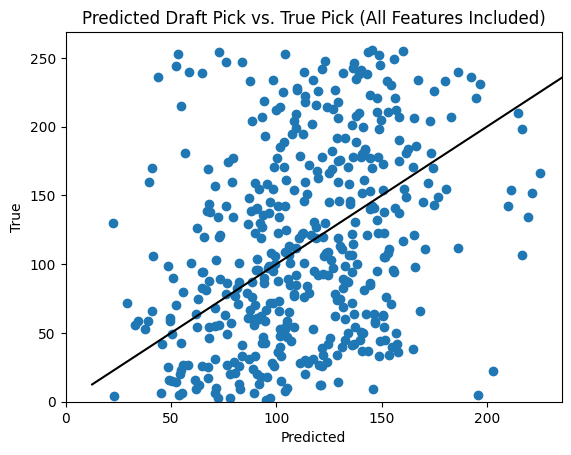

Top Weights:
category:  Saginaw Valley St.
weight:  [138.70655602]
category:  Georgia St.
weight:  [137.68050385]
category:  West Texas A&M
weight:  [135.78661639]
category:  South Dakota St.
weight:  [-125.67625141]
category:  New Hampshire
weight:  [125.60472593]
category:  Stephen F. Austin
weight:  [123.10271736]
category:  Liberty
weight:  [120.76328533]
category:  Midwestern St.
weight:  [-115.36584971]
category:  Newberry
weight:  [105.85902494]
category:  Weight
weight:  [-104.05441552]


In [105]:
#labels_real =["Year","Age", "Height","Weight","Sprint_40yd","Vertical_Jump", "Bench_Press_Reps",
#"Broad_Jump", "Agility_3cone", "Shuttle", "BMI","Age_NA","Sprint_40yd_NA",
#"Vertical_Jump_NA","Bench_Press_Reps_NA","Broad_Jump_NA","Agility_3cone_NA","Shuttle_NA"]

#list of possible cat lables: ["Position_Type", "Player_Type", "Position", "School" ]

num_labels =["Year", "Age","Height","Weight","Sprint_40yd","Vertical_Jump", "Bench_Press_Reps",
"Broad_Jump", "Agility_3cone", "Shuttle", "BMI","Age_NA","Sprint_40yd_NA",
"Vertical_Jump_NA","Bench_Press_Reps_NA","Broad_Jump_NA","Agility_3cone_NA","Shuttle_NA", "Offset"]
cat_labels = ["Position_Type", "Player_Type", "Position","School"]

plt.title("Predicted Draft Pick vs. True Pick (All Features Included)")
w, ll = run(df, cat_labels, num_labels, "pick")

print("Top Weights:")
top_abs_vals = sorted(range(len(w)), key=lambda i: abs(w[i]))[-10:]
#top_abs_vals
for x in reversed(top_abs_vals):
  print("category: ", ll[x])
  print("weight: ", w[x])

Excluding School

Train MSE	 4106.506563405056
Test MSE	 4326.167726782975


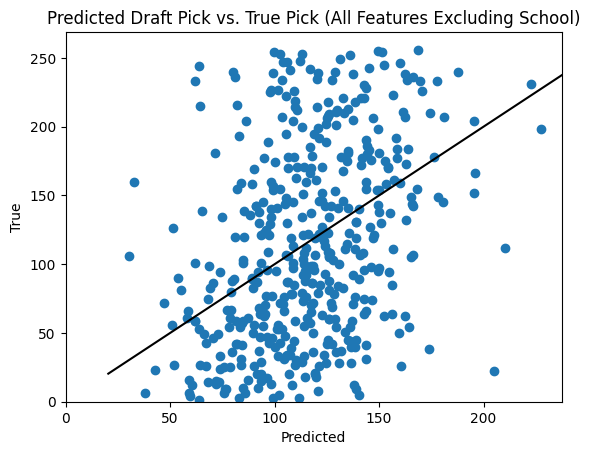

Top Weights:
category:  Weight
weight:  [-124.76724238]
category:  DB
weight:  [-81.90187794]
category:  Offset
weight:  [81.17574769]
category:  BMI
weight:  [64.52956195]
category:  Age_NA
weight:  [62.13024346]
category:  FB
weight:  [49.71151225]
category:  QB
weight:  [-43.43172083]
category:  special_teams
weight:  [33.67726119]
category:  Sprint_40yd
weight:  [30.98975769]
category:  LS
weight:  [28.92513947]


In [106]:
num_labels =["Year", "Age","Height","Weight","Sprint_40yd","Vertical_Jump", "Bench_Press_Reps",
"Broad_Jump", "Agility_3cone", "Shuttle", "BMI","Age_NA","Sprint_40yd_NA",
"Vertical_Jump_NA","Bench_Press_Reps_NA","Broad_Jump_NA","Agility_3cone_NA","Shuttle_NA", "Offset"]
cat_labels = ["Position_Type", "Player_Type", "Position"]

plt.title("Predicted Draft Pick vs. True Pick (All Features Excluding School)")
w, ll = run(df, cat_labels, num_labels, "pick")

print("Top Weights:")
top_abs_vals = sorted(range(len(w)), key=lambda i: abs(w[i]))[-10:]
#top_abs_vals
for x in reversed(top_abs_vals):
  print("category: ", ll[x])
  print("weight: ", w[x])

For Quaterback Postion Only

Train MSE	 4231.632655707753
Test MSE	 41885.254407559805


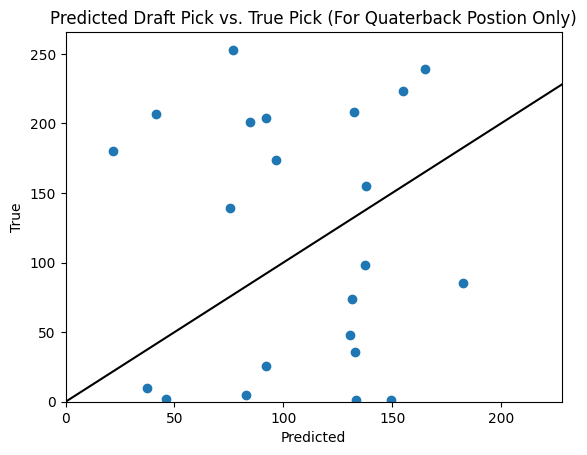

Top Weights:
category:  Bench_Press_Reps
weight:  [-1331.54972084]
category:  Bench_Press_Reps_NA
weight:  [96.18592218]
category:  Vertical_Jump_NA
weight:  [77.59636895]
category:  Broad_Jump
weight:  [-54.75751835]
category:  Broad_Jump_NA
weight:  [-40.56142765]
category:  Agility_3cone
weight:  [29.4149452]
category:  Vertical_Jump
weight:  [24.7859759]
category:  Sprint_40yd_NA
weight:  [15.65577863]
category:  Sprint_40yd
weight:  [9.13278041]
category:  BMI
weight:  [8.30743538]


In [107]:
num_labels =["Sprint_40yd","Vertical_Jump", "Bench_Press_Reps",
"Broad_Jump", "Agility_3cone", "Shuttle", "BMI", "Age_NA","Sprint_40yd_NA",
"Vertical_Jump_NA","Bench_Press_Reps_NA","Broad_Jump_NA","Agility_3cone_NA","Shuttle_NA"]

cat_labels = []
qb = df[df["Position"] == "QB"]

plt.title("Predicted Draft Pick vs. True Pick (For Quaterback Postion Only)")
w, ll = run(qb, cat_labels, num_labels, "pick", 0.8)

print("Top Weights:")
top_abs_vals = sorted(range(len(w)), key=lambda i: abs(w[i]))[-10:]
#top_abs_vals
for x in reversed(top_abs_vals):
  print("category: ", ll[x])
  print("weight: ", w[x])

Running Back Postion Only

Train MSE	 6405.6362590933095
Test MSE	 8820.68200793117


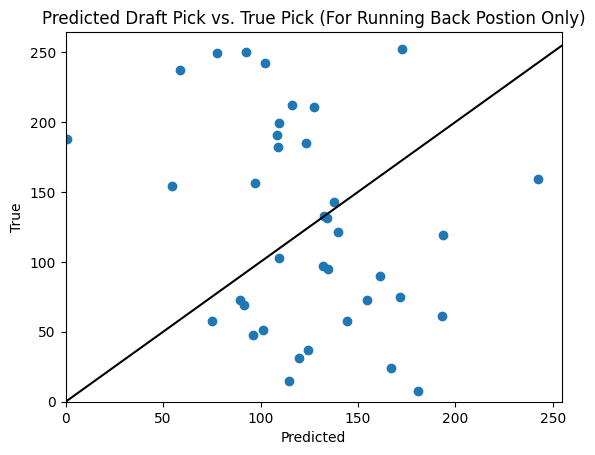

Top Weights:
category:  Age_NA
weight:  [124.81198217]
category:  Sprint_40yd_NA
weight:  [123.93160436]
category:  Sprint_40yd
weight:  [-95.51611558]
category:  Broad_Jump_NA
weight:  [-85.77806986]
category:  Agility_3cone_NA
weight:  [58.91396538]
category:  Vertical_Jump_NA
weight:  [41.23173327]
category:  Agility_3cone
weight:  [-34.99622832]
category:  Bench_Press_Reps_NA
weight:  [31.52797013]
category:  Shuttle
weight:  [-28.94755071]
category:  Bench_Press_Reps
weight:  [-21.070009]


In [108]:
num_labels =[ "Sprint_40yd","Vertical_Jump", "Bench_Press_Reps",
"Broad_Jump", "Agility_3cone", "Shuttle", "BMI", "Age_NA","Sprint_40yd_NA",
"Vertical_Jump_NA","Bench_Press_Reps_NA","Broad_Jump_NA","Agility_3cone_NA","Shuttle_NA"]

cat_labels = []
rb = df[df["Position"] == "RB"]

plt.title("Predicted Draft Pick vs. True Pick (For Running Back Postion Only)")
w, ll = run(rb, cat_labels, num_labels, "pick", 0.8)

print("Top Weights:")
top_abs_vals = sorted(range(len(w)), key=lambda i: abs(w[i]))[-10:]
#top_abs_vals
for x in reversed(top_abs_vals):
  print("category: ", ll[x])
  print("weight: ", w[x])

# Purity

In [109]:
import random as rand
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [110]:
X, y =  df , df['pick']

rng = np.random.RandomState(seed=42)
X["random_cat"] = rng.randint(3, size=X.shape[0])
X["random_num"] = rng.randn(X.shape[0])

num_labels =["Year", "Age", "Height","Weight","Sprint_40yd","Vertical_Jump", "Bench_Press_Reps",
"Broad_Jump", "Agility_3cone", "Shuttle", "BMI","Age_NA","Sprint_40yd_NA",
"Vertical_Jump_NA","Bench_Press_Reps_NA","Broad_Jump_NA","Agility_3cone_NA","Shuttle_NA"]
cat_labels = ["Position_Type", "Player_Type", "Position"]

X = X[cat_labels + num_labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [111]:
# got source code from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, cat_labels),
        ("num", numerical_pipe, num_labels),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline([("preprocess", preprocessing),("classifier", RandomForestClassifier(random_state=42)),])
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Position_Type',
                                                   'Player_Type', 'Position']),
                                                 ('num', SimpleImputer(),
                                                  ['Year', 'Age', 'Height',
                                                   'Weight', 'Sprint_40yd',
                                                   'Vertical_Jump',
                                                   'Bench_Press_Reps',
                                                   'Broad_Jump',
                                                   'Agility_3cone', 'Shuttle',
                                                   'BMI', 'Age_NA',
                                                   'Sprint_40yd_NA',
                                                   'Vertical_Jump_NA',
                                                   'Bench_Press_Reps_NA',
                                                   'Broad_Jump_NA',
                                                   'Agility_3cone_NA',
                                                   'Shuttle_NA'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [112]:
feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(rf[-1].feature_importances_, index=feature_names).sort_values(ascending=True)

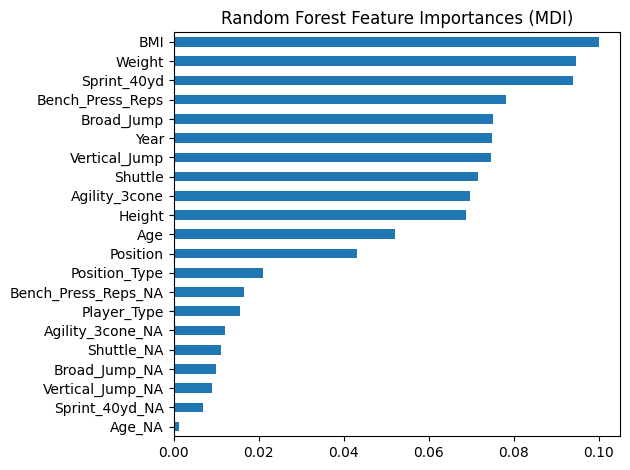

In [113]:
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()